<a href="https://colab.research.google.com/github/abir-tcheir/testGit/blob/main/VGG16_92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import zipfile
import datetime
from collections import Counter
 
import sklearn
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.utils import plot_model
 
from keras.layers import Activation, Dense
 
import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt

Non-COVID chest x-ray


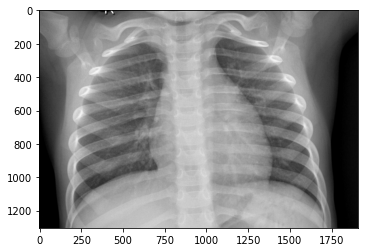

COVID chest x-ray


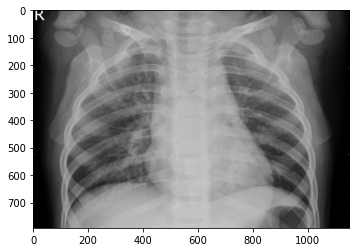

In [4]:
#img_path = '/content/COVID-19_Radiography_Dataset/'
img_path = '/content/drive/My Drive/datasetCOVIDB/'
#covid_imgs = '/content/COVID-19_Radiography_Dataset/COVID'
#normal_imgs = '/content/COVID-19_Radiography_Dataset/Normal'
#pneumonia_imgs = '/content/COVID-19_Radiography_Dataset/Viral Pneumonia'
 
covid_imgs = os.listdir(img_path+'/COVID')
normal_imgs = os.listdir(img_path+'/Non-COVID')
#pneumonia_imgs = os.listdir(img_path + '/Viral Pneumonia')
 
 
print("Non-COVID chest x-ray")
im = PIL.Image.open(os.path.join(img_path,'Non-COVID',normal_imgs[0]))
plt.imshow(im,cmap="gray")
plt.show()
 
print("COVID chest x-ray")
im = PIL.Image.open(os.path.join(img_path,'COVID',covid_imgs[0]))
plt.imshow(im,cmap="gray")
plt.show()
 
#print("Viral Pneumonia chest x-ray")
#im = PIL.Image.open(os.path.join(img_path,'Viral Pneumonia',pneumonia_imgs[0]))
#plt.imshow(im,cmap="gray")
#plt.show()

In [5]:
list_files = []
for dir in os.listdir(img_path):
  aux_dir = os.path.join(img_path,dir)
  
  if os.path.isdir(aux_dir):
    for img in os.listdir(aux_dir):
      list_files.append([os.path.join(dir,img),dir])
df = pd.DataFrame(list_files, columns=['id','label'])
df.describe()

,id,label
count,9545,9545
unique,9545,2
top,COVID/person49_virus_101.jpeg,Non-COVID
freq,1,5500


In [6]:
def frequency_plot(df):
  freq_abs = Counter(df.label);
  freq_a = pd.DataFrame.from_dict(freq_abs, orient='index').reset_index()
 # total = len(df.index)
#  freq_r = freq_a[0]/total
 # freq_a[1] = freq_r
  freq_a.columns = ['Label','absolute frequency']
  return freq_a
frequency_plot(df)

,Label,absolute frequency
0,Non-COVID,5500
1,COVID,4045


In [7]:
def split_dataset(df,test_size,random_state = 101):
  sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
  df = df.reset_index()
  for train_index, test_index in sss.split(df['id'], df['label']):
    X_train, X_test = df['id'][train_index], df['id'][test_index]
    y_train, y_test = df['label'][train_index], df['label'][test_index]
  traindf = pd.concat([X_train, y_train], axis=1)
  testdf = pd.concat([X_test, y_test], axis=1)
  return traindf,testdf
 
#divide train/val/test in 80/10/10
traindf,testdf = split_dataset(df,test_size = 0.25)
valdf,testdf= split_dataset(testdf,test_size = 0.50)
# traindf = balance_dataset('COVID',df)
 
 
traindf.id = img_path + traindf.id
valdf.id = img_path + valdf.id
testdf.id = img_path + testdf.id

In [8]:
frequency_plot(traindf)

,Label,absolute frequency
0,Non-COVID,4125
1,COVID,3033


In [9]:
frequency_plot(valdf)

,Label,absolute frequency
0,Non-COVID,687
1,COVID,506


In [10]:
frequency_plot(testdf)

,Label,absolute frequency
0,Non-COVID,688
1,COVID,506


In [11]:
BATCH_SIZE = 50
IMAGE_SIZE = 224
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)

In [12]:

"""
train_datagen = ImageDataGenerator(          
    rotation_range = 40,
    width_shift_range = 0.2,
  height_shift_range=0.2,
  shear_range = 0.2,
  zoom_range = 0.1,
  fill_mode = 'nearest',
)
"""
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
 
 
print("Creating train generator...")
train_generator = train_datagen.flow_from_dataframe(
    dataframe=traindf,
    directory="datasetCOVIDB",
    x_col="id",
    y_col="label",
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    seed=5,
    shuffle=True,
    #class_mode="categorical",
    #class_mode="binary",
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)
 
 
val_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_dataframe(
    dataframe=testdf,
    directory="datasetCOVIDB",
    x_col="id",
    y_col="label",
    color_mode="rgb",
    seed=5,
    shuffle = False,
    #batch_size=BATCH_SIZE,
    batch_size=30,
    #class_mode="binary",
    #class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)
 
print("\nCreating val generator...")
val_generator = val_datagen.flow_from_dataframe(
    dataframe=valdf,
    directory="datasetCOVIDB",
    x_col="id",
    y_col="label",
    batch_size=5,
    #batch_size=BATCH_SIZE,
    color_mode="rgb",
    seed=5,
    shuffle=True,
    #class_mode="binary",
   #class_mode="categorical",
    
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)

Creating train generator...


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 6 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 7152 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 1192 validated image filenames belonging to 2 classes.

Creating val generator...
Found 1193 validated image filenames belonging to 2 classes.


In [13]:
#!pip install -U git+https://github.com/qubvel/efficientnet

In [14]:
#import efficientnet.tfkeras as enet
#base_model =enet.EfficientNetB1(include_top=False, input_shape=(224,224,3), pooling='avg', weights="imagenet",classes=2)

from keras.applications.vgg16 import VGG16
base_model = VGG16(include_top=False, input_shape=input_shape,
                    weights='imagenet')

#from keras.applications.inception_v3 import InceptionV3 
#ase_model =InceptionV3(include_top=False, input_shape=input_shape,
                    #weights='imagenet')
 
 
#Freeze base convolutional layers
base_model.trainable = False
base_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [15]:
#from keras.layers import AveragePooling2D, BatchNormalization
from keras.regularizers import l1_l2
from keras.regularizers import l2
from keras.regularizers import l1
from keras.layers import Dropout
 
model = models.Sequential()
model.add(base_model)
 
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024,activation='relu'))
model.add(layers.Dropout(0.30))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024,activation='relu'))
model.add(layers.Dropout(0.30))
predictions=model.add(layers.Dense(2, activation='softmax'))
 
"""
# model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.Flatten())
 
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.30))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.30))
model.add(layers.Dense(1, activation='sigmoid',name="fc_out"))
 
 
x = base_model.output
 
x = BatchNormalization()(x)
x = Dropout(0.7)(x)
 
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
 
x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
# Output layer
predictions = Dense(1, activation="sigmoid")(x)
 
model= Model(inputs = base_model.input, outputs = predictions)
"""
#model.summary()

'\n# model.add(layers.Conv2D(64, 3, activation=\'relu\'))\nmodel.add(layers.Flatten())\n \nmodel.add(layers.Dense(1024, activation=\'relu\'))\nmodel.add(layers.Dropout(0.30))\nmodel.add(layers.Dense(1024, activation=\'relu\'))\nmodel.add(layers.Dropout(0.30))\nmodel.add(layers.Dense(1, activation=\'sigmoid\',name="fc_out"))\n \n \nx = base_model.output\n \nx = BatchNormalization()(x)\nx = Dropout(0.7)(x)\n \nx = Dense(512)(x)\nx = BatchNormalization()(x)\nx = Activation("relu")(x)\nx = Dropout(0.5)(x)\n \nx = Dense(128)(x)\nx = BatchNormalization()(x)\nx = Activation("relu")(x)\n# Output layer\npredictions = Dense(1, activation="sigmoid")(x)\n \nmodel= Model(inputs = base_model.input, outputs = predictions)\n'

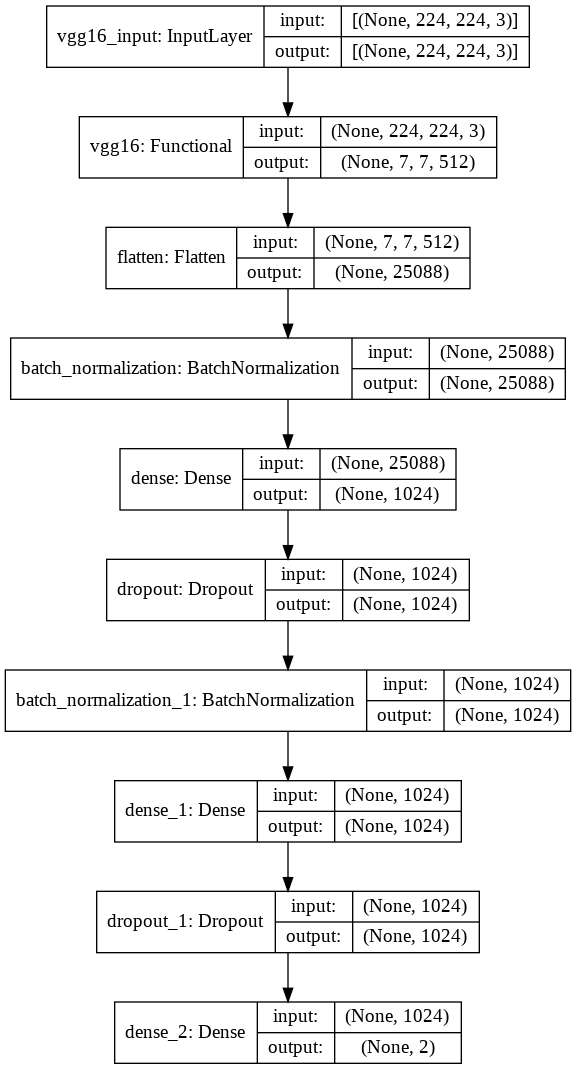

In [16]:
plot_model(model, to_file='model.png', show_shapes=True)
Image(filename='model.png')

In [17]:
 
 
 #base_convnet.trainable=True 
EPOCHS =21
LEARNING_RATE = 1e-5
DECAY= LEARNING_RATE/EPOCHS
model.compile(
     #loss='binary_crossentropy',
    loss='categorical_crossentropy',
    # optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
     optimizer = tf.keras.optimizers.Nadam(lr=LEARNING_RATE),
     metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),
             'acc']
)
 
#callbacks = [model_checkpoint_callback,early,mcp_save]
history = model.fit_generator(
    train_generator,
    steps_per_epoch = BATCH_SIZE,
    epochs=EPOCHS,
    #callbacks=callbacks,
    validation_data = val_generator,
    validation_steps=BATCH_SIZE,
    verbose=1
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/21
50/50 [==============================] - 685s 13s/step - loss: 0.6196 - recall: 0.7092 - precision: 0.7092 - acc: 0.7092 - val_loss: 0.5229 - val_recall: 0.7280 - val_precision: 0.7280 - val_acc: 0.7280
Epoch 2/21
50/50 [==============================] - 435s 9s/step - loss: 0.4198 - recall: 0.7957 - precision: 0.7957 - acc: 0.7957 - val_loss: 0.4742 - val_recall: 0.7880 - val_precision: 0.7880 - val_acc: 0.7880
Epoch 3/21
50/50 [==============================] - 298s 6s/step - loss: 0.3570 - recall: 0.8462 - precision: 0.8462 - acc: 0.8462 - val_loss: 0.4489 - val_recall: 0.7880 - val_precision: 0.7880 - val_acc: 0.7880
Epoch 4/21
50/50 [==============================] - 226s 4s/step - loss: 0.2875 - recall: 0.8732 - precision: 0.8732 - acc: 0.8732 - val_loss: 0.3630 - val_recall: 0.8480 - val_precision: 0.8480 - val_acc: 0.8480
Epoch 5/21
50/50 [==============================] - 166s 3s/step - loss: 0.2809 - recall: 0.8891 - precision: 0.8891 - acc: 0.8891 - val_loss: 0.33

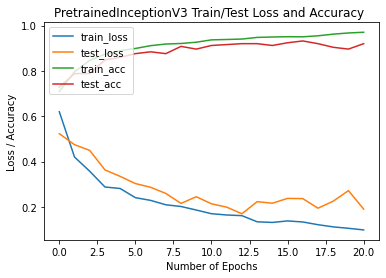

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

N = EPOCHS
#plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="test_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="test_acc")
plt.title("PretrainedInceptionV3 Train/Test Loss and Accuracy ")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss / Accuracy")
plt.legend(loc="upper left")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[468  38]
 [ 45 641]]
classification_Report
              precision    recall  f1-score   support

      COVID+       0.91      0.92      0.92       506
      COVID-       0.94      0.93      0.94       686

    accuracy                           0.93      1192
   macro avg       0.93      0.93      0.93      1192
weighted avg       0.93      0.93      0.93      1192



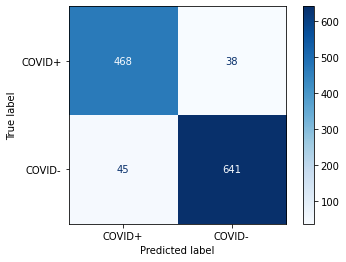

In [19]:
# Confusion Matrix  & Pres  & Recall   & F1-Score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

target_names = ['COVID+', 'COVID-']
label_names = [0,1]

Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred ,  axis = 1)

cm = confusion_matrix(test_generator.classes, y_pred, labels = label_names)


print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

print('classification_Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format = 'g')
plt.show()